# ReScience

This JupyterNotebook was created to produce the brain sections from Figure 2D, 2E and 3 from the article **[Re] Spread of alpha-synuclein pathology through the brain connectome is modulated by selective vulnerability and predicted by network analysis** submitted to ReScience.


*Requirements*: The Input directory must be the directory from the repository. 
The algorithm first needs to be runned to predict the spread after the initiation in the iPir and the iSN. (Figure3)
The output path can be modified.

### Imports

In [74]:
# Brainrender librairy
from vedo import embedWindow
embedWindow(None)
# from brainrender import Scene, atlas
# import brainrender

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import AxesGrid

from PIL import Image
import os

### Function

In [73]:
### Definition of the function used to create the colormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name="ternary_centered"):
    """
    Function to offset the “center” of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap’s dynamic range to be at zero
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap’s range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap’s range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0."""
    cdict = {
        "red": [],
        "green": [],
        "blue": [],
        "alpha": []
    }
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(start, midpoint, 128, endpoint=False),
        np.linspace(midpoint, stop, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict["red"].append((si, r, r))
        cdict["green"].append((si, g, g))
        cdict["blue"].append((si, b, b))
        cdict["alpha"].append((si, a, a))
    newcmap = colors.LinearSegmentedColormap(name, cdict)
    return newcmap

### Directories

#### Input

The input directory must be the main folder extracted in GitHub (PathoSpreading)

#### Output

In [66]:
# Output directories creation
output_directory = "./output"
folders_figures = ["PIR_MPIs", "SN_MPIs", "Colormaps",
               "Residuals_Mean_MPIs","SNCA_exp"]
for folder in folders_figures:
    os.makedirs("{}/ReScience_Figures/{}".format(output_directory, folder), exist_ok=True)

## Figure 3

#### A)  Piriform

In [ ]:
# Loading the data
cmap= plt.get_cmap("Reds") # Red colormap
data_pir = pd.read_csv('./output/_iPir/Tables/predicted_pathology_iPir.csv') # Prediction after simulation in the iPir
reg_names = pd.read_csv('./Data83018/BrainR_ROInames.csv') # Conversion table to match the brain regions used by Henderson et al. with those available in BrainRender

# Matching ROInames with BrainRender
for r in data_pir.index:
    
    names = reg_names[reg_names['ROInames'] == data_pir.loc[r, 'regions']]['BrainR']
    
    if len(names) > 1:
         data_pir.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        data_pir.loc[r, 'br_regions'] = names.values
        
for r in data_pir.index:
    
    if data_pir.loc[r, 'regions'][0] == 'i':
        data_pir.loc[r, 'hem'] = 'right'
    elif data_pir.loc[r, 'regions'][0] == 'c':
        data_pir.loc[r, 'hem'] = 'left' 
        
# Normalization
max_Pir= np.max(data_pir['MPI6'])
min_Pir = np.min(data_pir['MPI1'])

data_pir['MPI6'] = (data_pir['MPI6'] - min_Pir) / (max_Pir - min_Pir)
data_pir['MPI3'] = (data_pir['MPI3'] - min_Pir) / (max_Pir - min_Pir)
data_pir['MPI1'] = (data_pir['MPI1'] - min_Pir) / (max_Pir - min_Pir)
data_pir = data_pir.dropna()

# Iterative variables
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]


# Creation of the sections
for t in tqdm(timepoints):
    for section in list_coor:
        bregma = np.array([5400,  # AP    
              0,  # DV    
              5700,]) # ML

        bregma[0] = bregma[0] + section

        # Create a brainrender scene
        scene = Scene(inset=False,screenshots_folder="{}/ReScience_Figures/PIR_MPIs".format(output_directory))
        frontal_camera = {
             'pos': (-19781, 3777, -5832),
             'viewup': (0, -1, 0),
             'clippingRange': (24465, 26836),
            'focalPoint': (5705, 3991, -5691),
             'distance': 25487}

        # Add brain regions
        for r in data_pir.index:

            region_to_plot = data_pir.loc[r, "br_regions"]
            color = cmap(100*data_pir.loc[r, 'MPI{}'.format(t)])[:3]
            alpha =  cmap(data_pir.loc[r, 'MPI{}'.format(t)])[:3]
            scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=data_pir.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]
        
        # Sectionning the 3D brain into slices
        plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
        plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
        scene.slice(plane_1, close_actors=True)
        scene.slice(plane_2, close_actors=True)

        # Rendering parameters
        brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
        brainrender.settings.ROOT_ALPHA = 0.17
        brainrender.settings.LW =2.4
        brainrender.settings.ROOT_COLOR  = [0.5019, 0.5019, 0.5019]
        brainrender.settings.OFFSCREEN = True
        brainrender.settings.SHOW_AXES = False
        brainrender.settings.BACKGROUND_COLOR = "white"
        scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
        scene.screenshot(name="50um_Pir_MPI{}_Breg_{}_mm".format(t,-section/1000), scale = 3)
        scene.close()

####     $\color{green}{B)  Substantia Nigra}$

In [4]:
# Loading the data
cmap = plt.get_cmap('Reds') # Red colormap
data_sn = pd.read_csv('./output/_iSN/Tables/predicted_pathology_iSN.csv') # Prediction after simulation in the iSN
reg_names = pd.read_csv('./Data83018/BrainR_ROInames.csv') # Conversion table to match the brain regions used by Henderson et al. with those available in BrainRender

# Matching ROInames with BrainRender
for r in data_sn.index:
    
    names = reg_names[reg_names['ROInames'] == data_sn.loc[r, 'regions']]['BrainR']
    
    if len(names) > 1:
         data_sn.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        data_sn.loc[r, 'br_regions'] = names.values
        
for r in data_sn.index:
    
    if data_sn.loc[r, 'regions'][0] == 'i':
        data_sn.loc[r, 'hem'] = 'right'
    elif data_sn.loc[r, 'regions'][0] == 'c':
        data_sn.loc[r, 'hem'] = 'left' 
        
# Normalization
max_SN= np.max(data_sn['MPI6'])
min_SN = np.min(data_sn['MPI1'])

data_sn['MPI6'] = (data_sn['MPI6'] - min_SN) / (max_SN - min_SN)
data_sn['MPI3'] = (data_sn['MPI3'] - min_SN) / (max_SN - min_SN)
data_sn['MPI1'] = (data_sn['MPI1'] - min_SN) / (max_SN - min_SN)
data_sn = data_sn.dropna()

# Iterative variables
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]


# Creation of the sections
for t in tqdm(timepoints):
    for section in list_coor:
        bregma = np.array([5400,  # AP    
              0,  # DV    
              5700,]) # ML

        bregma[0] = bregma[0] + section

        # Create a brainrender scene
        scene = Scene(inset=False,screenshots_folder="{}/ReScience_Figures/SN_MPIs".format(output_directory))
        frontal_camera = {
             'pos': (-19781, 3777, -5832),
             'viewup': (0, -1, 0),
             'clippingRange': (25465, 26836),
            'focalPoint': (5705, 3991, -5691),
             'distance': 25487}

        # Add brain regions
        for r in data_sn.index:

            region_to_plot = data_sn.loc[r, "br_regions"]
            color = cmap(data_sn.loc[r, 'MPI{}'.format(t)])[:3]
            alpha =  cmap(data_sn.loc[r, 'MPI{}'.format(t)])[:3]
            scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=data_sn.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]

        # Sectionning the 3D brain into slices
        plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
        plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
        scene.slice(plane_1, close_actors=True)
        scene.slice(plane_2, close_actors=True)

        # Rendering parameters
        brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
        brainrender.settings.ROOT_ALPHA = 0.17
        brainrender.settings.LW =2.4
        brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
        brainrender.settings.OFFSCREEN = True
        brainrender.settings.SHOW_AXES = False
        brainrender.settings.BACKGROUND_COLOR = "white"
        scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
        scene.screenshot(name="50um_SNc_MPI{}_Breg_{}_mm".format(t,section/1000), scale = 3)
        scene.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_4.5_mm.png

 33%|███▎      | 1/3 [00:54<01:48, 54.43s/it]

Saving new screenshot at 50um_SNc_MPI3_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_4.5_mm.png

 67%|██████▋   | 2/3 [01:53<00:55, 55.76s/it]

Saving new screenshot at 50um_SNc_MPI6_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_4.5_mm.png

100%|██████████| 3/3 [02:51<00:00, 57.16s/it]


####     $\color{green}{C)  Color Map: Estimated percentage of area with \alpha-synuclein pathology }$

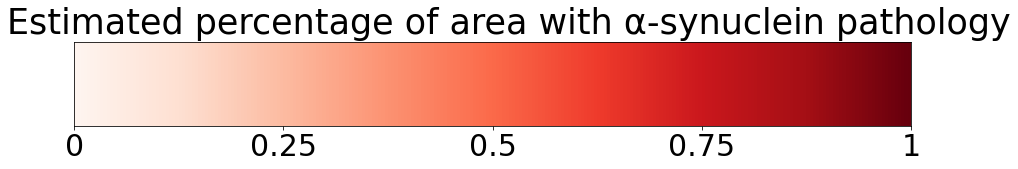

In [69]:
cmap = plt.cm.get_cmap('Reds')
colors = cmap(np.arange(cmap.N))
plt.figure(figsize=(15,3))
plt.imshow([colors], extent=[0, 10, 0, 1])
plt.xticks([0, 2.5, 5, 7.5 ,10], ['0', '0.25', '0.5','0.75','1'], fontsize=30)
plt.yticks([])
plt.text(-0.8,1.1,'Estimated percentage of area with \u03B1-synuclein pathology', fontsize=35)

plt.savefig("{}/ReScience_Figures/Colormaps/colormap_fig3.pdf".format(output_directory),dpi=300)


## Figure 2

#### A)  Figure 2 D: Heatmap of the residuals

In [ ]:
# Loading of the outputs of the model
resi_cpu1 = pd.read_csv('./output/_iCPu/Tables/model_output_MPI1_iCPu.csv')
resi_cpu3 = pd.read_csv('./output/_iCPu/Tables/model_output_MPI3_iCPu.csv')
resi_cpu6 = pd.read_csv('./output/_iCPu/Tables/model_output_MPI6_iCPu.csv')

# Saving for each timepoint a table containing only residuals
res1=pd.DataFrame(resi_cpu1["residual"].values, index=[resi_cpu1["Unnamed: 0"].values], columns=["MPI 1 residual"])
res3=pd.DataFrame(resi_cpu3["residual"].values, index=[resi_cpu3["Unnamed: 0"].values], columns=["MPI 3 residual"])
res6=pd.DataFrame(resi_cpu6["residual"].values, index=[resi_cpu6["Unnamed: 0"].values], columns=["MPI 6 residual"])

# Merging those tables in a table named "residuals"
res1_3= pd.merge(res1,res3, right_index=True, left_index=True, how="outer")
residuals = pd.merge(res1_3, res6, right_index=True, left_index=True, how="outer")

# Computing the mean of the residuals and saving it on the file "residuals"
mean_res= pd.DataFrame(np.nanmean(residuals.values, axis=1), columns=["Mean MPI Residuals"]) # Computing the arithmetic mean along the axis 1, ignoring the NaN values
reg_res= pd.DataFrame([i[0] for i in residuals.index.values], columns=["region"])
residuals = pd.merge(reg_res,mean_res, right_index=True, left_index=True, how="outer")
# print(residuals) # The table containings the mean of the residuals

# Matching ROInames with BrainRender
for r in residuals.index:
    
    names = reg_names[reg_names['ROInames'] == residuals.loc[r, 'region']]['BrainR']
    
    if len(names) > 1:
        residuals.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        residuals.loc[r, 'br_regions'] = names.values
        
for r in residuals.index:
    
    if residuals.loc[r, 'region'][0] == 'i':
        residuals.loc[r, 'hem'] = 'right'
    elif residuals.loc[r, 'region'][0] == 'c':
        residuals.loc[r, 'hem'] = 'left' 
        
# Extraction of the midpoint to generate a colormap consequently shifted.
max_resi_cpu = np.max(residuals["Mean MPI Residuals"])
min_resi_cpu = np.min(residuals["Mean MPI Residuals"])
mid_pt= 1 - (max_resi_cpu) / (max_resi_cpu + np.abs(min_resi_cpu))
print("mid_pt is",mid_pt)
cmap = shiftedColorMap(cmap=plt.get_cmap("bwr"), start=0.0, midpoint=mid_pt, stop=1.0, name="ternary_centered")

# Normalization
residuals["Mean MPI Residuals"]= (residuals["Mean MPI Residuals"]- min_resi_cpu)/(max_resi_cpu-min_resi_cpu)
residuals["Mean MPI Residuals"]
residuals = residuals.dropna() #Dropping the br_regions overlapping in brain render

# Iterative variables
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]

# Creation of the sections
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="{}/ReScience_Figures/Residuals_Mean_MPIs".format(output_directory))
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in residuals.index:

        region_to_plot = residuals.loc[r, "br_regions"]
        color = cmap(residuals.loc[r, "Mean MPI Residuals"])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=residuals.loc[r, 'hem'], silhouette=True) 

    # Sectionning the 3D brain into slices
    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)

    # Rendering parameters
    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.17
    brainrender.settings.LW =2.4
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="50um_Mean_MPI_Breg_{}_mm".format(-section/1000), scale = 3)
    
    # Tranposing the image
    img_totranspose = Image.open("{}/ReScience_Figures/Residuals_Mean_MPIs/50um_Mean_MPI_Breg_{}_mm.png".format(output_directory, -section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("{}/ReScience_Figures/Residuals_Mean_MPIs/50um_Mean_MPI_Breg_{}_mm.png".format(output_directory, -section/1000))
    scene.close()

#### B)  Figure 2 E: Colormap of the relative vulnerability

In [ ]:
cmap=shiftedColorMap(cmap=plt.get_cmap("bwr"), start=0.0, midpoint=mid_pt, stop=1.0, name="ternary_centered")
cmap = plt.cm.get_cmap(cmap)
colors = cmap(np.arange(cmap.N))
plt.figure(figsize=(15,3))
plt.imshow([colors], extent=[0, 10, 0, 1])
plt.xticks([0, 2.5, 5, 7.5 ,10], ['0', '0.25', '0.5','0.75','1'], fontsize=30)
plt.yticks([])
plt.text(2.9,1.1,'Relative vulnerability', fontsize=35)

plt.savefig("{}/ReScience_Figures/Colormaps/colormap_fig2D.pdf".format(output_directory),dpi=300)

#### C)  Figure 2 E: Heatmap of SNCA expression

In [48]:
# Loading the data
reg_names = pd.read_csv('./Data83018/BrainR_ROInames.csv')
snca_exp = pd.read_csv('./Data83018/SncaExpression.csv', header=None)
snca_exp.columns= ["Regions","SNCA_val"]
cmap=plt.get_cmap("YlOrRd")

# Matching ROInames with BrainRender
for r in snca_exp.index:
    
    names = reg_names[reg_names['ROInames'] == snca_exp.loc[r, 'Regions']]['BrainR']
    
    if len(names) > 1:
         snca_exp.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        snca_exp.loc[r, 'br_regions'] = names.values   
        
for r in snca_exp.index:
    
    if snca_exp.loc[r, 'Regions'][0] == 'i':
        snca_exp.loc[r, 'hem'] = 'right'
    elif snca_exp.loc[r, 'Regions'][0] == 'c':
        snca_exp.loc[r, 'hem'] = 'left'
        
snca_exp= snca_exp.dropna() #Dropping the br_regions overlapping in brain render
max_val= np.max(snca_exp["SNCA_val"].values)
min_val= np.min(snca_exp["SNCA_val"].values)

# Normalization
snca_exp["SNCA_val"]=(snca_exp["SNCA_val"] - min_val)/(max_val-min_val)

# Iterative variables
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]

# Creation of the sections
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="{}/ReScience_Figures/SNCA_exp".format(output_directory))
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in snca_exp.index:

        region_to_plot = snca_exp.loc[r, "br_regions"]
        color = cmap(snca_exp.loc[r, 'SNCA_val'])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=snca_exp.loc[r, 'hem'], silhouette=True) #alpha=snca_exp.loc[r, 'SNCA_val'])

    # Sectionning the 3D brain into slices
    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)

    # Rendering parameters
    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.17
    brainrender.settings.LW = 2.4
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="SNCA_exp_Breg{}.png".format(-section/1000), scale = 3)
    
    # Tranposing the image
    img_totranspose = Image.open("{}/ReScience_Figures/SNCA_exp/SNCA_exp_Breg{}.png".format(output_directory, -section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("{}/ReScience_Figures/SNCA_exp/SNCA_exp_Breg{}.png".format(output_directory, -section/1000))
    scene.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Saving new screenshot at SNCA_exp_Breg2. 1. png

 20%|██        | 1/5 [00:16<01:04, 16.09s/it]

Saving new screenshot at SNCA_exp_Breg1. 08. png

 40%|████      | 2/5 [00:32<00:48, 16.05s/it]

Saving new screenshot at SNCA_exp_Breg- 1.36 .png

 60%|██████    | 3/5 [00:48<00:32, 16.26s/it]

Saving new screenshot at SNCA_exp_Breg- 2.82 .png

 80%|████████  | 4/5 [01:07<00:16, 16.90s/it]

Saving new screenshot at SNCA_exp_Breg- 4.5 .png

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


#### D)  Figure 2 E: Heatmap of SNCA expression

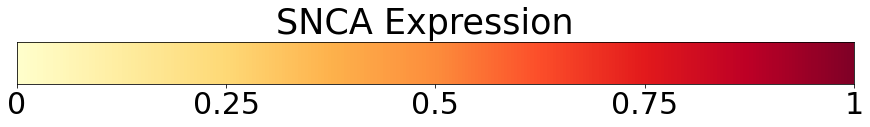

In [76]:
output_folder = "./colormap_fig2E/"

cmap = plt.cm.get_cmap('YlOrRd')
colors = cmap(np.arange(cmap.N))
plt.figure(figsize=(15,3))
plt.imshow([colors], extent=[0, 10, 0, 0.5])
plt.xticks([0, 2.5, 5, 7.5 ,10], ["0", '0.25', '0.5','0.75','1'],fontsize=30)
plt.yticks([])
plt.text(3.1,0.6,'SNCA Expression',fontsize=35)

plt.savefig("{}/ReScience_Figures/Colormaps/colormap_fig2E.pdf".format(output_directory),dpi=300)
